In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import librosa
from tqdm import tqdm_notebook as tqdm
import scipy
import matplotlib.pyplot as plt
import plotly
import cufflinks as cf
%matplotlib inline

In [2]:
wav_dir = '/media/tomoya/SSD-PGU3/research/asd/USV_Data'
sr = 300000
info = []

for wav_path in tqdm(sorted(list(Path(wav_dir).iterdir()))):
    wav, _ = librosa.load(str(wav_path), sr=sr)
    info.append(wav.shape[0])
    break
pd.Series(info).describe()

count           1.0
mean     90046464.0
std             NaN
min      90046464.0
25%      90046464.0
50%      90046464.0
75%      90046464.0
max      90046464.0
dtype: float64

In [3]:
pd.Series(np.array(info) / sr).describe()

count      1.00000
mean     300.15488
std            NaN
min      300.15488
25%      300.15488
50%      300.15488
75%      300.15488
max      300.15488
dtype: float64

In [4]:
2**18

262144

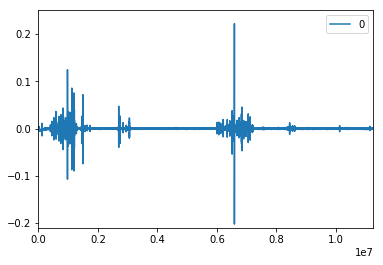

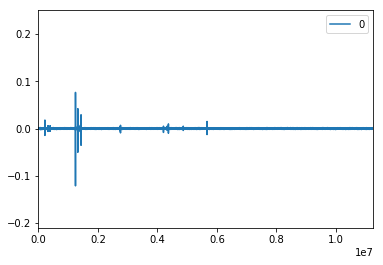

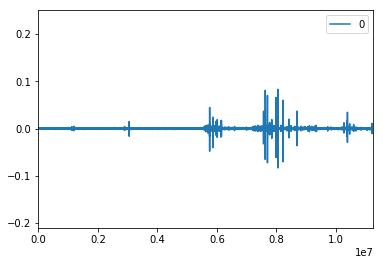

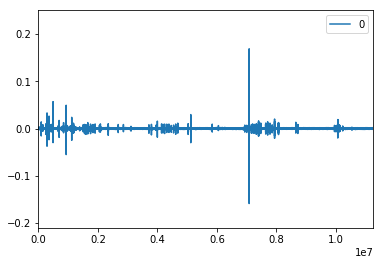

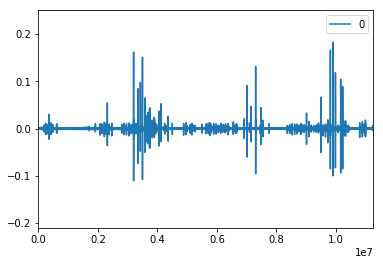

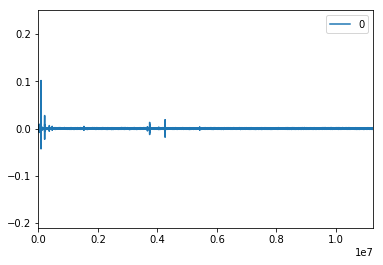

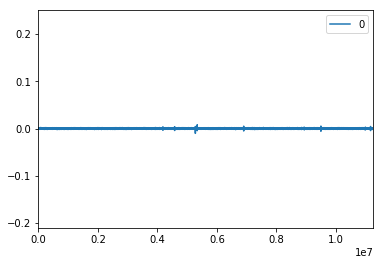

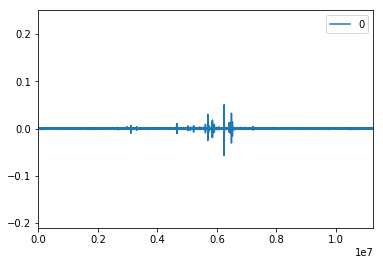

In [5]:
n = 8
one_length = wav.shape[0] // 8

for i in range(n):
    pd.DataFrame(wav[one_length * i:one_length * (i + 1)]).plot()
    plt.ylim(-0.21, 0.25)
    plt.show()

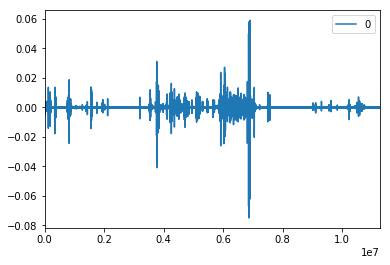

In [6]:
pd.DataFrame(scipy.signal.decimate(wav, 8)).plot()

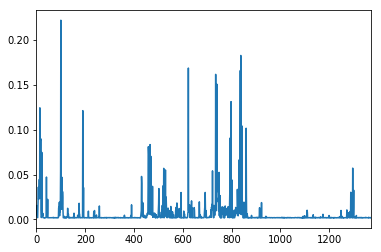

In [7]:
pd.Series(np.abs(wav).reshape((-1, 8192 * 8)).max(axis=1).reshape((-1))).plot()

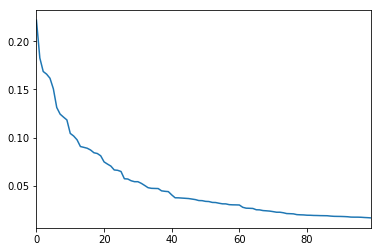

In [8]:
maxed_signal = np.abs(wav).reshape((-1, 8192 * 8)).max(axis=1).reshape((-1))
pd.Series(maxed_signal[maxed_signal.argsort()[::-1][:100]]).plot()

In [9]:
def cut_pad_wave(wave, sr, one_audio_sec):
    const_length = sr * one_audio_sec
    if wave.shape[0] > const_length:
        wave = wave[:const_length]
    elif wave.shape[0] < const_length:
        n_pad = (const_length - wave.shape[0]) // 2 + 1
        wave = np.pad(wave[:const_length], n_pad, mode='mean')[:const_length]
        
    assert wave.shape[0] == const_length
    return wave

# Pilot study

### Dataset preparation

In [10]:
pip install xlrd

Note: you may need to restart the kernel to use updated packages.


In [11]:
label_df = pd.read_excel('/media/tomoya/SSD-PGU3/research/asd/P08_12_USV_15qDup_MouseInfo.xlsx')
label_kind = {'pat': 1, 'WT': 0}
subj2label = dict(zip(label_df['MouseID'], label_df['Genotype']))

In [12]:
pd.Series(wav).describe()

count    9.004646e+07
mean     2.149277e-05
std      7.499087e-04
min     -2.021179e-01
25%     -2.746582e-04
50%      3.051758e-05
75%      3.356934e-04
max      2.219543e-01
dtype: float64

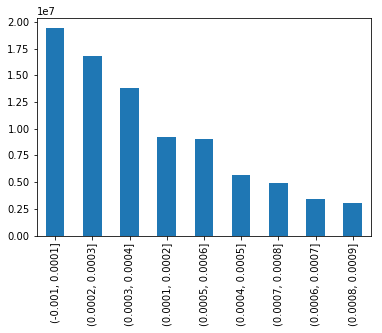

In [21]:
pd.Series(np.abs(wav)).value_counts(bins=np.arange(0, 0.001, 0.0001)).plot.bar()

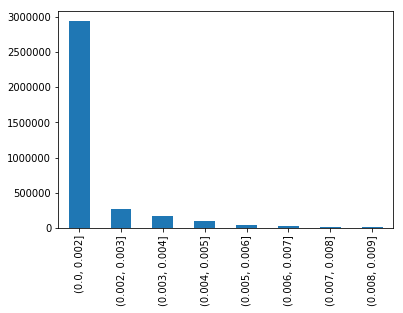

In [24]:
pd.Series(np.abs(wav)).value_counts(bins=np.arange(0.001, 0.01, 0.001)).plot.bar()

In [27]:
pd.Series(np.abs(wav)).value_counts(bins=np.arange(0.01, 0.1, 0.01))

(0.009000000000000001, 0.02]    47683
(0.02, 0.03]                     8705
(0.03, 0.04]                     2197
(0.04, 0.05]                      484
(0.05, 0.06]                      188
(0.06, 0.07]                       96
(0.07, 0.08]                       59
(0.08, 0.09]                       33
dtype: int64

In [ ]:
pd.Series(wav[np.abs(wav) > np.abs(wav.mean()) + wav.std() * 2]).plot()

In [ ]:
upper_300 = []

for wav_path in tqdm(sorted(list(Path(wav_dir).iterdir()))):
    wav, _ = librosa.load(str(wav_path), sr=sr)
    wav = cut_pad_wave(wav, sr, one_audio_sec=5 * 60)
    wav = wav[np.abs(wav) > np.abs(wav.mean()) + wav.std() * 2
#     maxed_signal = np.abs(wav).reshape((-1, 10000)).max(axis=1).reshape((-1))
    upper_300.append(wav[wav.argsort()[::-1][:300]])
    
df = pd.DataFrame(upper_300)
df['wav_path'] = sorted([p.name for p in Path(wav_dir).iterdir()])
df['label'] = df['wav_path'].apply(lambda x: label_kind[subj2label[x[:3]]])
df.head()

In [ ]:
df[0].plot()

### Logistic regression

In [ ]:
x = df.drop('wav_path', axis=1).drop('label', axis=1).values
x = (x - x.mean(axis=0)) / x.std(axis=0)
y = df['label']

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, balanced_accuracy_score

#### Upper 50 

In [ ]:
lr = LogisticRegression()
lr.fit(x[:, :50], y)
pd.Series(lr.coef_.reshape((-1))).plot()
print(lr.intercept_)

pred = lr.predict(x[:, :50])
print(balanced_accuracy_score(y, pred))
confusion_matrix(y, pred)

#### Upper 100

In [ ]:
lr = LogisticRegression()
lr.fit(x[:, :100], y)
pd.Series(lr.coef_.reshape((-1))).plot()
print(lr.intercept_)

pred = lr.predict(x[:, :100])
print(balanced_accuracy_score(y, pred))
confusion_matrix(y, pred)

#### Upper 300

In [ ]:
lr = LogisticRegression()
lr.fit(x[:, :300], y)
pd.Series(lr.coef_.reshape((-1))).plot()
print(lr.intercept_)

pred = lr.predict(x[:, :300])
print(balanced_accuracy_score(y, pred))
confusion_matrix(y, pred)

## Fourlier transform

In [ ]:
wav_pad = cut_pad_wave(wav, sr, one_audio_sec=5 * 60)
spectrum = np.abs(scipy.fftpack.fft(wav_pad))
print(spectrum.shape)

In [ ]:
pd.Series(spectrum).plot()

In [ ]:
spectrum_list = []

for wav_path in tqdm(sorted(list(Path(wav_dir).iterdir()))):
    wav, _ = librosa.load(str(wav_path), sr=sr)
    wav = cut_pad_wave(wav, sr, one_audio_sec=5 * 60)
    spectrum = np.abs(scipy.fftpack.fft(wav))
    spectrum_list.append()
    
df = pd.DataFrame(upper_300)
df['wav_path'] = sorted([p.name for p in Path(wav_dir).iterdir()])
df['label'] = df['wav_path'].apply(lambda x: label_kind[subj2label[x[:3]]])
df.head()